### librerie

In [ ]:
import sys
import os
import shutil
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.image import extract_patches

from keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
from keras import Input, Model
from keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import cv2

sns.set_style('darkgrid')

warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
import random

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Callback per salvare il modello con la migliore accuratezza di validazione
checkpoint_cb = ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_accuracy')

# Callback per fermare l'addestramento se non c'è miglioramento in 'patience' epoche
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy')


### DATASET

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'chest-xray-pneumonia:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F17810%2F23812%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240127%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240127T113032Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6fdddea08edc34bddc05a6a83e93561b640a8cf13dd82f7622d1de5ba70e6ba33c7e786aa2bb788b87b64ed0e167fd383d43bf1cb4f6054177a97224d24e7cfd3b1e30c82360bf5e4606c7b0519dda6d08be507c7c8989a5e8d5b6e021328e60ecc23467795b6525aa6427729e2183b10772364f545e50eef48b25caae5c5ab9288acc15ea7aa61c4edd1731b5703c185eafe86555848db7d5e0b5c60d5d66783a4237aed487c7f128e87f083f1c667e969361fb6739098d98494afa0ea7ef6305198f28ca86818d0a27627c7acca7fb3722c70840dd4946cc3b9c4106ece9443acaf6cbeb60f43e9f0182299bd18e7b57d2b9ebac85758bf19b0c041d82cd57'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2463365435 bytes downloaded
Downloaded and uncompressed: chest-xray-pneumonia
Data source import complete.


### PRE-PROCESSING

In [ ]:
DATA_ROOT = '/kaggle/input/chest-xray-pneumonia/chest_xray'

DATA_TRAIN = os.path.join(DATA_ROOT, "train")
DATA_VALID = os.path.join(DATA_ROOT, "val")
DATA_TEST  = os.path.join(DATA_ROOT, "test")

LABELS = ['NORMAL', 'PNEUMONIA']
IMAGE_SIZE = (224, 224)
PATCH_SIZE = 16
BATCH_SIZE = 32

In [ ]:
def get_datasource(*data_dirs, flag=cv2.IMREAD_GRAYSCALE):
    x, y = list(), list()
    for data_dir in data_dirs:
        for i, label in enumerate(LABELS):
            path = os.path.join(data_dir, label)
            target = [0] * len(LABELS)
            target[i] = 1
            for img in os.listdir(path):
                if img.endswith(".jpeg"):
                    img_arr = cv2.imread(os.path.join(path, img), flag)
                    resized_arr = cv2.resize(img_arr, IMAGE_SIZE)
                    x.append(resized_arr)
                    y.append(target)
    return np.array(x) / 255, np.array(y)

In [ ]:
x_train, y_train = get_datasource(DATA_TRAIN, DATA_VALID)
x_test, y_test = get_datasource(DATA_TEST)

x_train = np.expand_dims(x_train, axis=-1)
x_test  = np.expand_dims(x_test, axis=-1)

### DATASET 2

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Configurazione per il download del dataset Open Images V4
config = tfds.download.DownloadConfig(manual_dir='/path/to/manual/dataset')

# Caricamento del dataset Open Images V4
# Questo passaggio potrebbe richiedere molto tempo e spazio su disco a seconda delle dimensioni del subset che stai scaricando
dataset, info = tfds.load('open_images_v4', with_info=True, download_and_prepare_kwargs={'download_config': config})

# Stampa delle informazioni sul dataset
print(info)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

### EFFICIENT NET B0 MODEL

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Carica il modello EfficientNetB0 preaddestrato senza il top layer (layer di output)
base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))  # Assicurati che input_shape sia (224, 224, 3)


16705208/16705208 [==============================] - 2s 0us/step


In [ ]:
# Crea il modello aggiungendo nuovi layer
model = models.Sequential([
    layers.Input(shape=(224, 224, 1)),  # L'input originale è in scala di grigi
    layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x)),  # Converte in RGB duplicando i canali
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(len(LABELS), activation='softmax')  # len(LABELS) corrisponde al numero di classi
])

In [ ]:
# Compila il modello
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Stampa il sommario del modello per controllare la sua architettura
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 2

In [ ]:
history_model = model.fit(
    x_train, y_train,
    epochs= 15,
    batch_size= BATCH_SIZE,
    validation_data=(x_test, y_test),
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/15
164/164 [==============================] - ETA: 0s - loss: 0.1173 - accuracy: 0.9528

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


164/164 [==============================] - 92s 280ms/step - loss: 0.1173 - accuracy: 0.9528 - val_loss: 1.6399 - val_accuracy: 0.6250
Epoch 2/15
164/164 [==============================] - 42s 255ms/step - loss: 0.0664 - accuracy: 0.9759 - val_loss: 6.4260 - val_accuracy: 0.6250
Epoch 3/15
164/164 [==============================] - 42s 257ms/step - loss: 0.0407 - accuracy: 0.9855 - val_loss: 4.6082 - val_accuracy: 0.6250
Epoch 4/15
164/164 [==============================] - 42s 255ms/step - loss: 0.0292 - accuracy: 0.9910 - val_loss: 2.7916 - val_accuracy: 0.6250
Epoch 5/15
164/164 [==============================] - 42s 255ms/step - loss: 0.0241 - accuracy: 0.9922 - val_loss: 1.8103 - val_accuracy: 0.6250
Epoch 6/15
164/164 [==============================] - 42s 256ms/step - loss: 0.0326 - accuracy: 0.9891 - val_loss: 3.1148 - val_accuracy: 0.6250
Epoch 7/15
164/164 [==============================] - 42s 257ms/step - loss: 0.0193 - accuracy: 0.9935 - val_loss: 43.6053 - val_accuracy: 0.

### EFFICIENT NET B0 CON LORA

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

class LoRADenseLayer(layers.Layer):
    def __init__(self, units, rank, activation=None, **kwargs):
        super(LoRADenseLayer, self).__init__(**kwargs)
        self.units = units
        self.rank = rank
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        # Pesi originali del layer Dense
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='glorot_uniform',
                                 trainable=True)

        # Matrici LoRA
        self.A = self.add_weight(shape=(input_shape[-1], self.rank),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.B = self.add_weight(shape=(self.rank, self.units),
                                 initializer='glorot_uniform',
                                 trainable=True)

    def call(self, inputs):
        # Calcolo originale + modifica LoRA
        z = tf.matmul(inputs, self.w) + tf.matmul(inputs, self.A @ self.B)
        return self.activation(z) if self.activation is not None else z




In [ ]:
model_with_lora = models.Sequential([
    layers.Input(shape=(224, 224, 1)),
    layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x)),
    base_model,
    layers.GlobalAveragePooling2D(),
    LoRADenseLayer(128, rank=32, activation='relu'),  # Layer Dense con LoRA
    layers.Dropout(0.2),
    LoRADenseLayer(len(LABELS), rank=16, activation='softmax')  # Layer di output con LoRA
])

# Compilazione e sommario del modello
model_with_lora.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_with_lora.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 lo_ra_dense_layer (LoRADen  (None, 128)               208896    
 seLayer)                                                        
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                      

In [ ]:
history_model_with_lora = model_with_lora.fit(
    x_train, y_train,
    epochs= 15,
    batch_size= BATCH_SIZE,
    validation_data=(x_test, y_test),
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/15
164/164 [==============================] - 80s 277ms/step - loss: 0.0734 - accuracy: 0.9774 - val_loss: 5.6762 - val_accuracy: 0.6250
Epoch 2/15
164/164 [==============================] - 42s 258ms/step - loss: 0.0657 - accuracy: 0.9780 - val_loss: 11.5907 - val_accuracy: 0.6250
Epoch 3/15
164/164 [==============================] - 42s 256ms/step - loss: 0.0444 - accuracy: 0.9841 - val_loss: 2.1249 - val_accuracy: 0.6250
Epoch 4/15
164/164 [==============================] - 42s 256ms/step - loss: 0.0363 - accuracy: 0.9870 - val_loss: 2.2575 - val_accuracy: 0.6250
Epoch 5/15
164/164 [==============================] - 42s 256ms/step - loss: 0.0202 - accuracy: 0.9929 - val_loss: 3.7605 - val_accuracy: 0.6250
Epoch 6/15
164/164 [==============================] - 42s 255ms/step - loss: 0.0264 - accuracy: 0.9899 - val_loss: 25.4143 - val_accuracy: 0.6250
Epoch 7/15
164/164 [==============================] - 42s 256ms/step - loss: 0.0171 - accuracy: 0.9935 - val_loss: 180.0134 - va

### compare two model

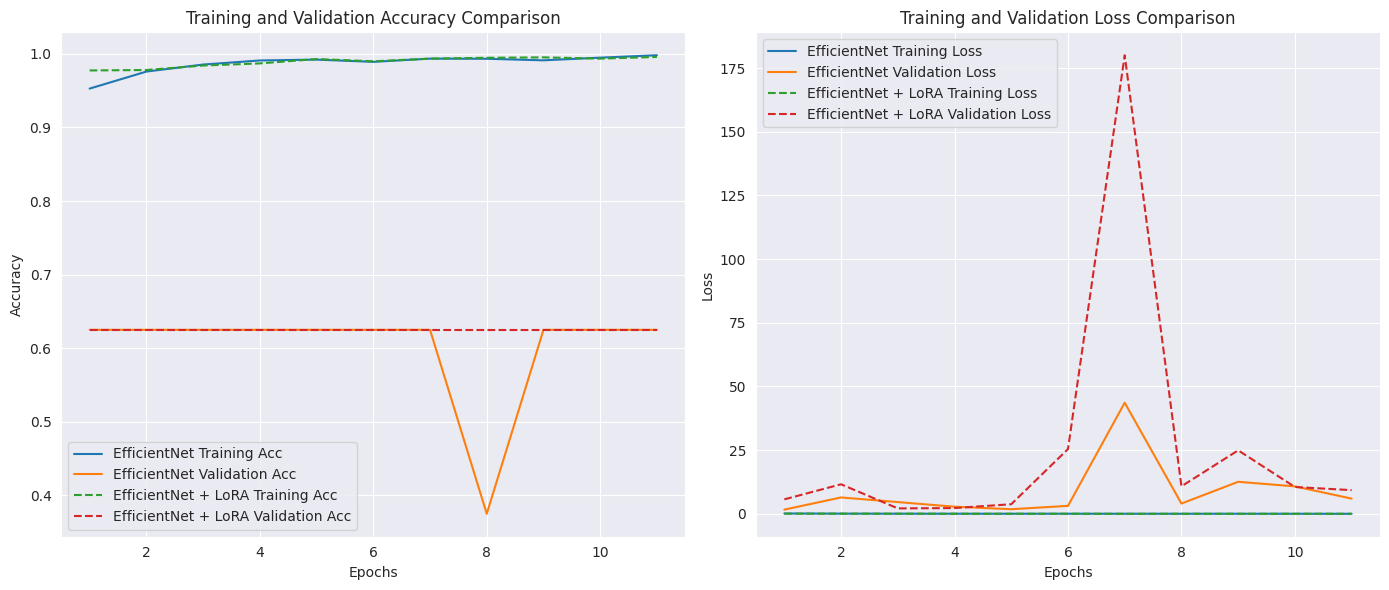

In [ ]:
import matplotlib.pyplot as plt

def compare_models(history_model, history_model_with_lora, title1='efficient-net', title2='efficient-net + LOrA'):
    acc1 = history_model.history['accuracy']
    val_acc1 = history_model.history['val_accuracy']
    loss1 = history_model.history['loss']
    val_loss1 = history_model.history['val_loss']

    acc2 = history_model_with_lora.history['accuracy']
    val_acc2 = history_model_with_lora.history['val_accuracy']
    loss2 = history_model_with_lora.history['loss']
    val_loss2 = history_model_with_lora.history['val_loss']

    epochs = range(1, len(acc1) + 1)

    plt.figure(figsize=(14, 6))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc1, label=f'{title1} Training Acc')
    plt.plot(epochs, val_acc1, label=f'{title1} Validation Acc')
    plt.plot(epochs, acc2, label=f'{title2} Training Acc', linestyle='--')
    plt.plot(epochs, val_acc2, label=f'{title2} Validation Acc', linestyle='--')
    plt.title('Training and Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss1, label=f'{title1} Training Loss')
    plt.plot(epochs, val_loss1, label=f'{title1} Validation Loss')
    plt.plot(epochs, loss2, label=f'{title2} Training Loss', linestyle='--')
    plt.plot(epochs, val_loss2, label=f'{title2} Validation Loss', linestyle='--')
    plt.title('Training and Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Usiamo le history dei due modelli per fare il plot
compare_models(history_model, history_model_with_lora, 'EfficientNet', 'EfficientNet + LoRA')
